In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA


from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
loader.add_tag_intensity_score()
prepared_df = loader.add_gender_code(loader.prepared_df)
tag_columns = loader.tag_cols
prepared_df.columns

tag_intensity_score = loader.find_agg_tag_columns("tag_intensity_score")
loader.add_column_zscores_standardized(columns = tag_intensity_score)
z_score_cols = loader.find_agg_tag_columns("zscore_tag_intensity_")
z_score_cols

prepared_df = loader.prepared_df

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)


Using seed: 18787288


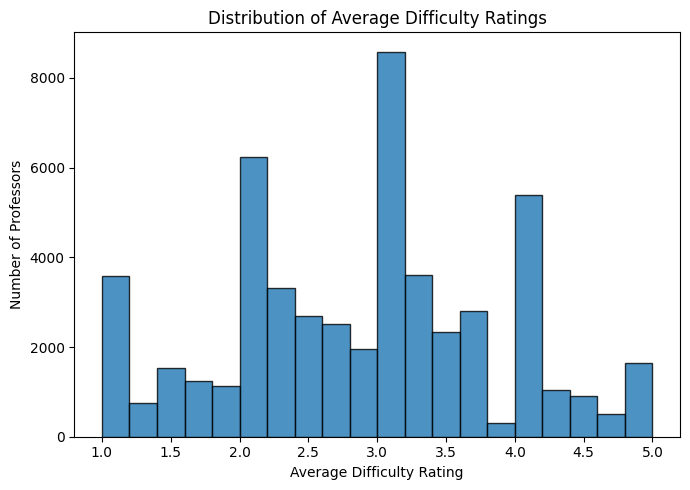

In [2]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(
    prepared_df["avg_difficulty"],
    bins=20,
    edgecolor="black",
    alpha=0.8
)

ax.set_xlabel("Average Difficulty Rating")
ax.set_ylabel("Number of Professors")
ax.set_title("Distribution of Average Difficulty Ratings")

plt.tight_layout()
plt.show()


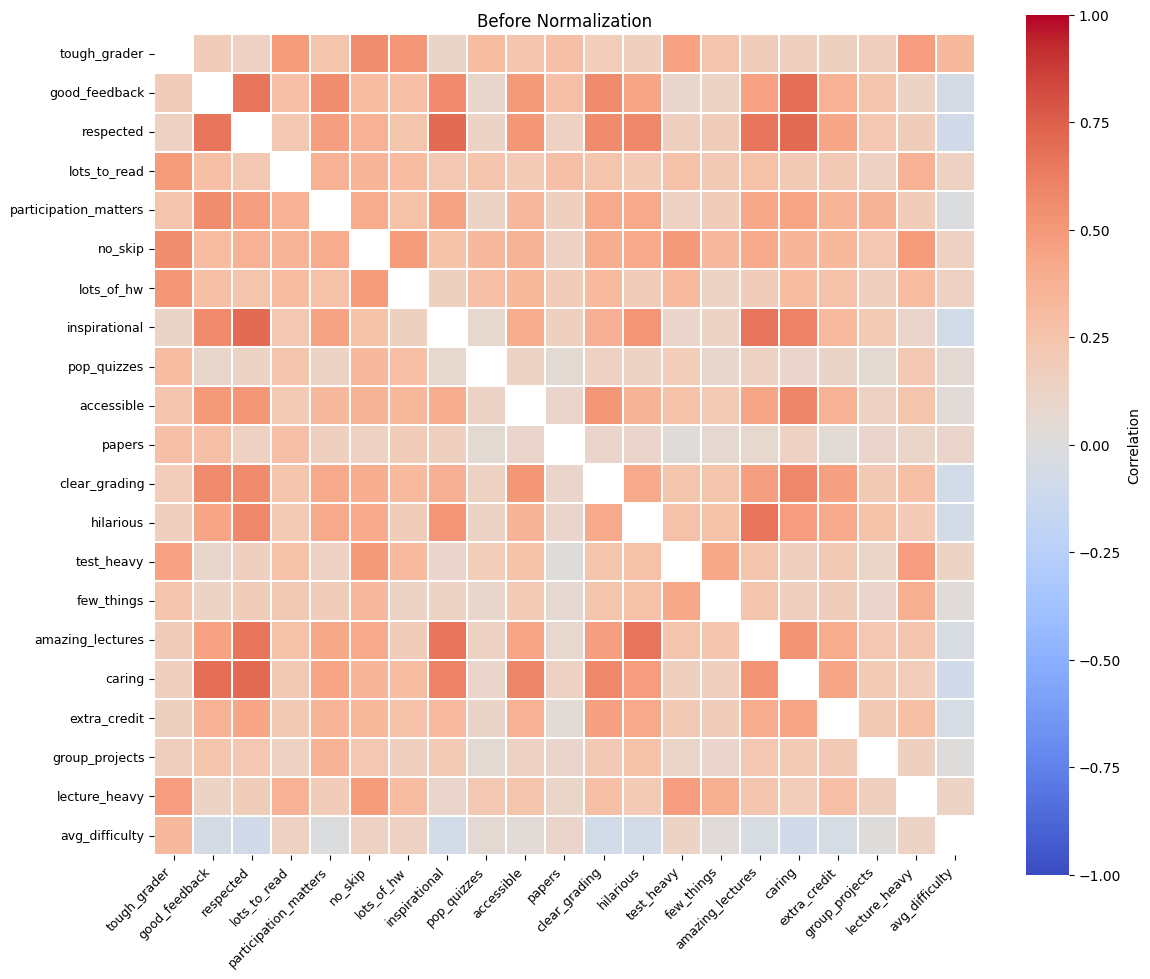

In [3]:
tag_cols = tag_columns + ["avg_difficulty"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Before Normalization")
plt.tight_layout()
plt.show()



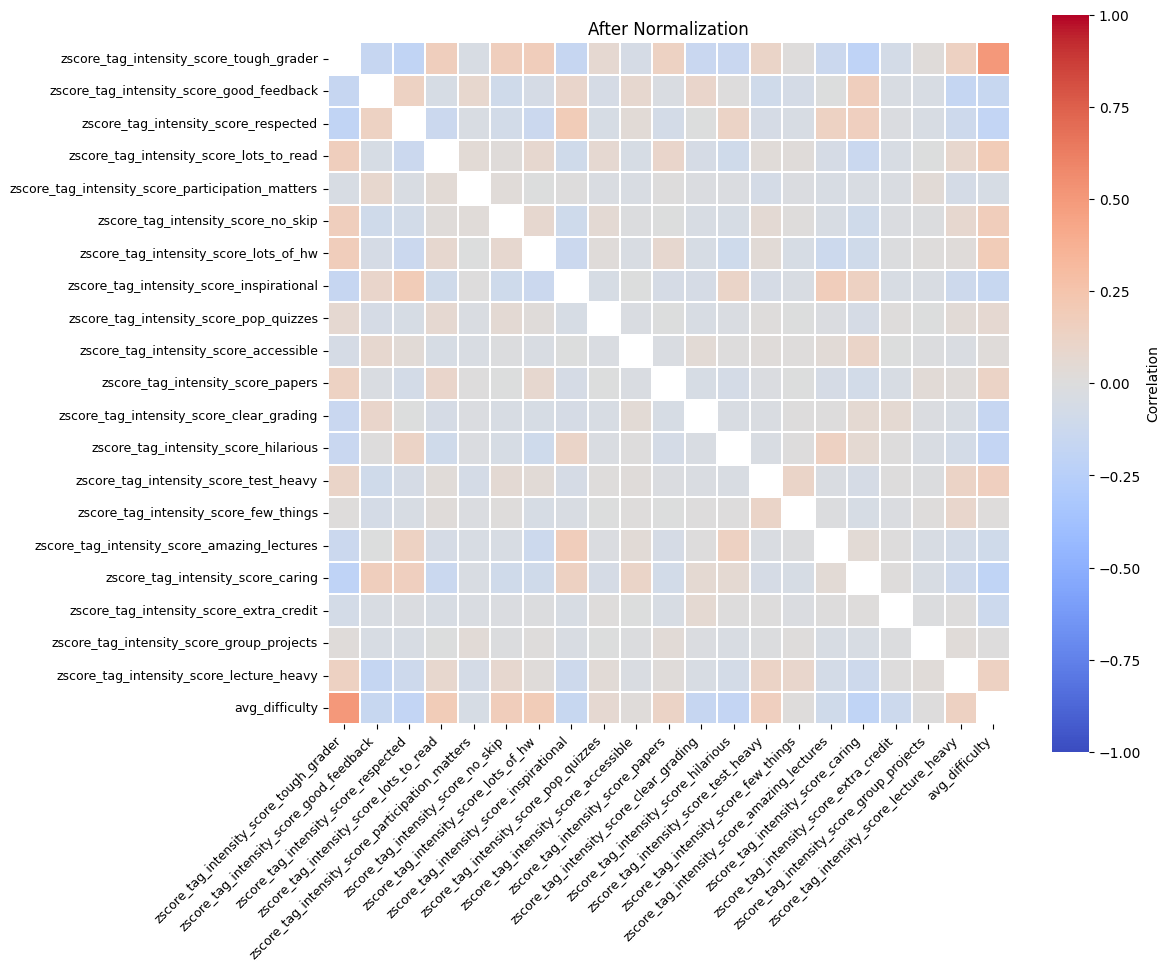

In [4]:
tag_cols = z_score_cols + ["avg_difficulty"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("After Normalization")
plt.tight_layout()
plt.show()

In [5]:
pca = PCA()

Y = prepared_df['avg_difficulty']
X = prepared_df[z_score_cols]

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(
    X_pca,
    index=prepared_df.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca = pd.concat([Y, X_pca_df], axis=1)
df_pca.head()

explained_var = pca.explained_variance_ratio_
pcs = np.arange(1, len(explained_var) + 1)


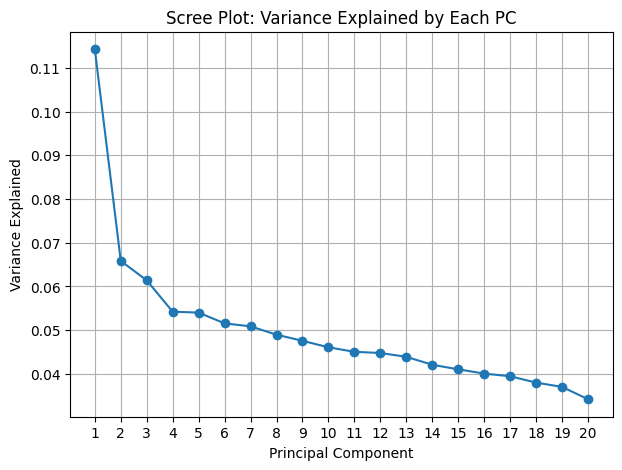

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(pcs, explained_var, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot: Variance Explained by Each PC")
plt.xticks(pcs)
plt.grid(True)
plt.show()

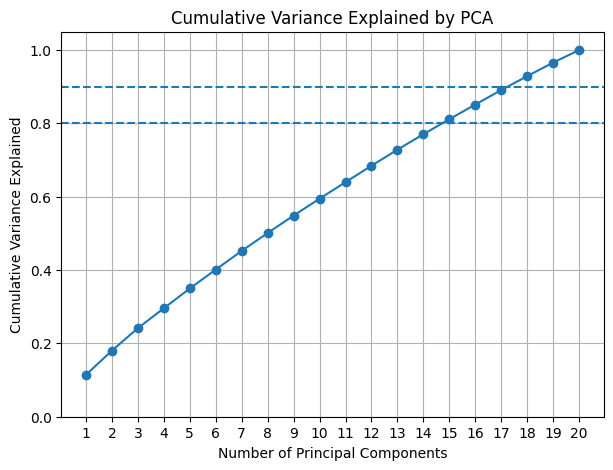

In [7]:
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(7, 5))
plt.plot(pcs, cum_var, marker='o')
plt.axhline(0.8, linestyle='--')
plt.axhline(0.9, linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA")
plt.xticks(pcs)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


In [8]:
# corr_with_y = corr_matrix["avg_rating"].abs().sort_values(ascending=False)
# selected_features = corr_with_y[corr_with_y > 0.15].index.drop("avg_rating")

# print(selected_features)

k_folds = MODEL_HELPER.kfold_split(n_splits = 5)

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X_pca,
    y=prepared_df["avg_rating"],
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

print(sum(res["rmse"]) / 5, np.var(res["rmse"], ddof=1), np.std(res["rmse"], ddof=1))
print(sum(res["r2"]) / 5, np.var(res["r2"], ddof=1), np.std(res["r2"], ddof=1))

top_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=X_pca_df.columns
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.head(5)
    top_scores[i] = feat
  
coef_df = []

for fold, series in top_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_top5=("feature", "count")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary


0.790405278605689 4.814464128729264e-05 0.006938633964066172
0.4974673969901233 2.17308085081464e-05 0.004661631528568769


,mean_abs_coef,times_in_top5
feature,,
PC1,0.494128,5
PC17,0.172007,5
PC7,0.076523,5
PC15,0.071621,5
PC13,0.068157,5


In [9]:
loadings = pca.components_.T
pc1_loadings = pd.Series(
    pca.components_[0],
    index=z_score_cols
).sort_values(key=np.abs, ascending=False)

pc1_loadings.head(10)


zscore_tag_intensity_score_tough_grader        0.406138
zscore_tag_intensity_score_respected          -0.336625
zscore_tag_intensity_score_caring             -0.323000
zscore_tag_intensity_score_inspirational      -0.309875
zscore_tag_intensity_score_good_feedback      -0.268246
zscore_tag_intensity_score_lecture_heavy       0.259357
zscore_tag_intensity_score_lots_to_read        0.251961
zscore_tag_intensity_score_lots_of_hw          0.247669
zscore_tag_intensity_score_amazing_lectures   -0.231083
zscore_tag_intensity_score_hilarious          -0.224553
dtype: float64

In [10]:
# corr_with_y = corr_matrix["avg_rating"].abs().sort_values(ascending=False)
# selected_features = corr_with_y[corr_with_y > 0.15].index.drop("avg_rating")

# print(selected_features)

# k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X,
    y=prepared_df["avg_rating"],
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

print(sum(res["rmse"]) / 5, np.var(res["rmse"], ddof=1), np.std(res["rmse"], ddof=1))
print(sum(res["r2"]) / 5, np.var(res["r2"], ddof=1), np.std(res["r2"], ddof=1))

top_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=X.columns
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.head(10)
    top_scores[i] = feat
  
coef_df = []

for fold, series in top_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["val_coef"] = tmp["coef"]
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_top5=("feature", "count"),
        min_coef=("val_coef", "min"),
        max_coef=("val_coef", "max")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary


0.7904052786056888 4.814464128728206e-05 0.00693863396406541
0.4974673969901236 2.1730808508133036e-05 0.004661631528567336


,mean_abs_coef,times_in_top5,min_coef,max_coef
feature,,,,
zscore_tag_intensity_score_tough_grader,0.275400,5,-0.277897,-0.272645
zscore_tag_intensity_score_good_feedback,0.246817,5,0.243434,0.248914
zscore_tag_intensity_score_respected,0.177815,5,0.173932,0.180436
zscore_tag_intensity_score_caring,0.177560,5,0.175712,0.180303
zscore_tag_intensity_score_amazing_lectures,0.167975,5,0.166623,0.169306
zscore_tag_intensity_score_clear_grading,0.132976,5,0.128259,0.137938
zscore_tag_intensity_score_hilarious,0.130794,5,0.129209,0.132798
zscore_tag_intensity_score_inspirational,0.115534,5,0.113827,0.116781
zscore_tag_intensity_score_lecture_heavy,0.103748,5,-0.106249,-0.101486
